In [47]:
# Last mod: FA 2023 Feb 17

# Predicting ages from spectroscopic abundances with XGBoost 
## Using the updated training set from Miglio+2023

In [3]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter

import astropy.table
from astropy.table import Table, Column, MaskedColumn 
from astropy.visualization import astropy_mpl_style
from scipy.stats import gaussian_kde
from scipy.interpolate import make_interp_spline

import os.path

from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
import shap

from itertools import product
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15) 

# Import the training table (APOGEE-Kepler dataset)

We use the table containing asteroseismic+spectroscopic age estimates from [Miglio et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021A%26A...645A..85M/abstract) - updated to APOGEE DR17:

In [4]:
miglio2021 = Table.read("../data/Kepler_10-02-2023_Rcut.csv")
names = [name for name in miglio2021.colnames if len(miglio2021[name].shape) <= 1]
miglio2021.keep_columns(names)
mig = miglio2021.to_pandas()
mig = mig.rename(columns={"LOGG_APO": "LOGG"})
mig.head()

,source_id,designation,ra_edr3,dec_edr3,l,b,ecl_lon,ecl_lat,parallax,pmra,...,mu0_68U,mu0_95L,mu0_95U,dist,dist_68L,dist_68U,dist_95L,dist_95U,nfil,fils
0,2075131938920399616,Gaia EDR3 2075131938920399616,299.183141,41.125814,76.259962,6.400805,317.062532,59.887287,1.597852,-10.407899,...,-99.900000,-99.900000,-99.900000,-99.900000,-99.900000,-99.900000,-99.900000,-99.900000,11,grizJHKsW1W2W3W4
1,2105626412861962368,Gaia EDR3 2105626412861962368,286.956025,43.240036,74.011459,15.429851,300.078498,64.918618,1.060335,-12.250130,...,9.866099,9.789489,9.891418,928.886719,917.871094,940.126953,907.539062,951.152344,10,grizJHKsW1W2W3
2,2106816840357141632,Gaia EDR3 2106816840357141632,284.304249,45.385362,75.353878,17.988762,296.953745,67.490782,0.654513,-2.648822,...,10.800267,10.737538,10.822442,1430.859375,1417.011719,1445.429688,1404.238281,1460.253906,10,grizJHKsW1W2W3
3,2129929399406642432,Gaia EDR3 2129929399406642432,291.099059,49.222802,80.882392,15.188348,312.360718,69.577808,0.693673,3.791181,...,10.759237,10.694819,10.780912,1403.281250,1389.082031,1418.378906,1376.894531,1432.597656,10,grizJHKsW1W2W3
4,2081902181758188032,Gaia EDR3 2081902181758188032,301.598537,44.460623,80.054111,6.621623,323.261496,62.182210,0.774694,3.107945,...,-99.900000,-99.900000,-99.900000,-99.900000,-99.900000,-99.900000,-99.900000,-99.900000,11,grizJHKsW1W2W3W4


In [5]:
list(mig.columns)

['source_id',
 'designation',
 'ra_edr3',
 'dec_edr3',
 'l',
 'b',
 'ecl_lon',
 'ecl_lat',
 'parallax',
 'pmra',
 'pmdec',
 'phot_g_mean_mag',
 'phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'ra_error',
 'dec_error',
 'parallax_error',
 'pmra_error',
 'pmdec_error',
 'ruwe',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_gof_al',
 'astrometric_matched_transits',
 'astrometric_n_bad_obs_al',
 'astrometric_n_good_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_obs_al',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_sigma5d_max',
 'bp_g',
 'bp_rp',
 'dec_parallax_corr',
 'dec_pmdec_corr',
 'dec_pmra_corr',
 'dec_pseudocolour_corr',
 'dr2_radial_velocity',
 'dr2_radial_velocity_error',
 'dr2_rv_nb_transits',
 'dr2_rv_template_fe_h',
 'dr2_rv_template_logg',
 'dr2_rv_template_teff',
 'duplicated_source',
 'g_rp',
 'ipd_frac_multi_peak',
 'ipd_frac_odd_win',
 'ipd_gof_harmonic_amplitude',
 'ipd_gof_harmonic_phase',
 

There is also a column informing about the evolutionary state (RC / RGB):

In [6]:
print("RGB stars:", np.sum(mig['evstate']==1))
print("RC  stars:", np.sum(mig['evstate']==2))
print("unidentified:", np.sum((mig['evstate']!=1) & (mig['evstate']!=2)))

RGB stars: 2441
RC  stars: 2353
unidentified: 191


We'll also have a look at the APOGEE DR17 abundance flags:

In [7]:
for columns in mig:
    if columns.endswith("_FLAG"):
        print(columns)
        print(mig[str(columns)].value_counts())
        print()

WASH_DDO51_GIANT_FLAG
-1    4985
Name: WASH_DDO51_GIANT_FLAG, dtype: int64

WASH_DDO51_STAR_FLAG
1    4985
Name: WASH_DDO51_STAR_FLAG, dtype: int64

RV_FLAG
0    4985
Name: RV_FLAG, dtype: int64

C_FE_FLAG
0      4984
256       1
Name: C_FE_FLAG, dtype: int64

CI_FE_FLAG
0      4982
256       3
Name: CI_FE_FLAG, dtype: int64

N_FE_FLAG
0      4922
256      54
288       7
32        2
Name: N_FE_FLAG, dtype: int64

O_FE_FLAG
0    4985
Name: O_FE_FLAG, dtype: int64

NA_FE_FLAG
0      4977
1         5
256       3
Name: NA_FE_FLAG, dtype: int64

MG_FE_FLAG
0    4985
Name: MG_FE_FLAG, dtype: int64

AL_FE_FLAG
0      4984
256       1
Name: AL_FE_FLAG, dtype: int64

SI_FE_FLAG
0    4985
Name: SI_FE_FLAG, dtype: int64

P_FE_FLAG
2      4930
258      45
3         6
259       4
Name: P_FE_FLAG, dtype: int64

S_FE_FLAG
0      4984
256       1
Name: S_FE_FLAG, dtype: int64

K_FE_FLAG
0      4982
1         2
256       1
Name: K_FE_FLAG, dtype: int64

CA_FE_FLAG
0    4985
Name: CA_FE_FLAG, dtype: int

## Data selection criteria

We need to cut out the "young $\alpha$-rich" stars:

(0.0, 15.0, -0.1, 0.4)

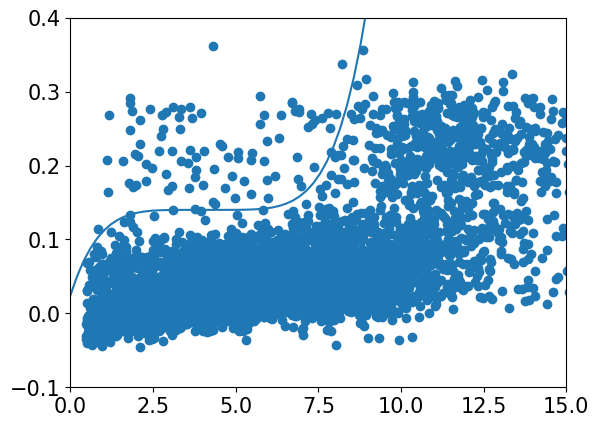

In [8]:
plt.scatter(mig["age"], mig["ALPHA_M"])
xx=np.linspace(0,10)
plt.plot(xx, 0.14+0.0001*(xx-4.1)**5)
plt.axis([0,15,-.1,.4])

Looking at the FLAG values above, we decide not to use [P/Fe] and [Cu/Fe].

For all other abundances, we require the corresponding FLAG to equal zero. In addition, we require a minimum APOGEE SNR of 50 and a RV_FLAG=0. We also apply some curation to the Miglio+ catalogue: age < 15, relative age uncertainty < 30 %, evstate either 1 (RGB) or 2 (RC):

In [9]:
mig = mig[(mig['RV_FLAG'] == 0)   & (mig['C_FE_FLAG'] == 0)   & \
          (mig['CI_FE_FLAG'] == 0)& (mig['N_FE_FLAG'] == 0)   & \
          (mig['O_FE_FLAG'] == 0) & (mig['NA_FE_FLAG'] == 0)  & \
          (mig['S_FE_FLAG'] == 0) & (mig['TIII_FE_FLAG'] == 0)& \
          (mig['V_FE_FLAG'] == 0) & (mig['CE_FE_FLAG'] == 0)  & \
          (mig['SNREV'] >= 70) & \
          (0.5 * (mig['age_68U'] - mig['age_68L']) / mig["age"] < 0.3) & \
          (0.5 * (mig['age_68U'] - mig['age_68L']) < 3) & \
          (mig["age"] > 0)    & (mig["age"] < 15) & \
          (mig['evstate']>=1) & (mig['evstate']<=2) & \
          ((mig['evstate']==2) | (mig['rad']<=11)) & \
          (mig["ALPHA_M"] < 0.14+0.0001*(mig["age"]-4.1)**5)
         ]

In [10]:
print(len(mig), "suffice the FLAG conditions")

4221 suffice the FLAG conditions


(array([   5.,   10.,   41.,  202.,  528.,  857., 1177.,  941.,  386.,
          74.]),
 array([-0.94692 , -0.806273, -0.665626, -0.524979, -0.384332, -0.243685,
        -0.103038,  0.037609,  0.178256,  0.318903,  0.45955 ]),
 <BarContainer object of 10 artists>)

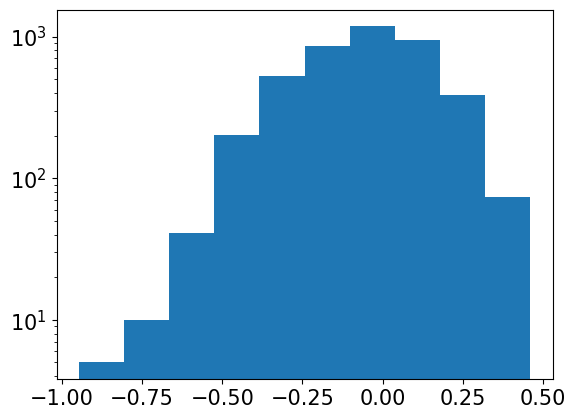

In [11]:
plt.hist(mig["FE_H"], log=True)

## Some plots (overplotting the training set over the full APOGEE DR17 data):

The APOGEE DR17 allStar file is big, so it's not included in the data folder. Even the "light" version is 1.7 GB:
* Data model: https://data.sdss.org/datamodel/files/APOGEE_ASPCAP/APRED_VERS/ASPCAP_VERS/allStar.html
* "Lite" file for download: https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits

The following cell reads the DR17 table:

In [12]:
apogee_data = "../data/allStarLite-dr17-synspec_rev1.fits"

if os.path.exists(apogee_data):
    pass
else:
    # Download the APOGEE DR17 "lite" version: (this can take a while...)
    os.system('wget https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits')
    os.system('mv allStarLite-dr17-synspec_rev1.fits ../data/.')

# Read and convert to pandas
apogee_dr17 = Table.read(apogee_data)
names = [name for name in apogee_dr17.colnames if len(apogee_dr17[name].shape) <= 1]
apogee_dr17.keep_columns(names)
big   = apogee_dr17.to_pandas()

print('Number of rows: ' +str(len(big)))
big.head()

Number of rows: 733901


,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,b'VESTA',b'apo1m',b'calibration',b' ',NaN,NaN,292.219131,-30.602919,99.999001,0.000,...,0.010266,0,NaN,NaN,0.059403,2,NaN,NaN,NaN,64
1,b'2M00000002+7417074',b'apo25m',b'120+12',b'none',0.000103,74.285408,119.401807,11.767414,8.597000,0.039,...,0.010609,0,NaN,NaN,0.001221,2,NaN,NaN,NaN,64
2,b'2M00000019-1924498',b'apo25m',b'060-75',b'none',0.000832,-19.413851,63.394122,-75.906397,11.074000,0.022,...,0.013835,0,NaN,NaN,0.102594,2,NaN,NaN,NaN,64
3,b'2M00000032+5737103',b'apo25m',b'116-04',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.016555,0,NaN,NaN,0.123839,2,NaN,NaN,NaN,64
4,b'2M00000032+5737103',b'apo25m',b'N7789',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.012638,0,NaN,NaN,0.107103,2,NaN,NaN,NaN,64


Define the same selection as for the training set:

In [13]:
selection = (big['TEFF'] < 5200) & (big['TEFF'] > 4400) & \
            (big['LOGG'] < 3.4)  & (big['LOGG'] > 2.2)  & \
            (big['FE_H'] > -1)   & (big['SNREV'] >= 50) & \
            (big['TEFF_ERR'] < 150) & (big['RV_FLAG'] == 0)  & \
            (big['C_FE_FLAG'] == 0) & (big['N_FE_FLAG'] == 0) & \
            (big['CI_FE_FLAG'] == 0)& (big['O_FE_FLAG'] == 0)  & \
            (big['TI_FE_FLAG'] == 0)& (big['CA_FE_FLAG'] == 0)  & \
            (big['AL_FE_FLAG'] == 0)& (big['CO_FE_FLAG'] == 0)  & \
            (big['NI_FE_FLAG'] == 0)& (big['MN_FE_FLAG'] == 0)

print(np.sum(selection), "stars with good quality")

194344 stars with good quality


### $T_{\rm eff}-\log g$ diagram

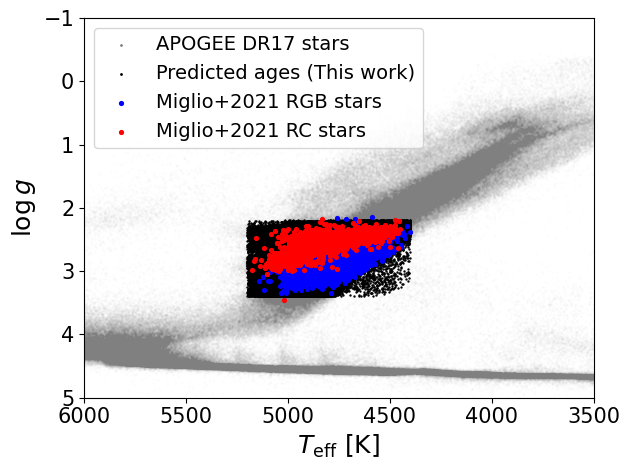

In [14]:
rgb = (mig['evstate']==1)
rc  = (mig['evstate']==2)

plt.scatter(big['TEFF'], big['LOGG'], c="grey", alpha=0.01, s=1, label="_nolabel")
plt.scatter(-999, -999, c="grey", alpha=1, s=1, label="APOGEE DR17 stars")
plt.scatter(big['TEFF'][selection], big['LOGG'][selection], c="k", s=.5, label="_nolabel")
plt.scatter(-999, -999, c="k", alpha=1, s=1, label="Predicted ages (This work)")
plt.scatter(mig['TEFF'][rgb], mig['LOGG'][rgb], s=7.5, c="b", label="Miglio+2021 RGB stars")
plt.scatter(mig['TEFF'][rc],  mig['LOGG'][rc],  s=7.5, c="red", label="Miglio+2021 RC stars")
plt.axis([6000, 3500, 5, -1.])
plt.xlabel(r"$T_{\rm eff}$ [K]", fontsize=18)
plt.ylabel(r"$\log g$", fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.tight_layout()
plt.savefig("../im/kiel_diagram.png", dpi=300)

### Age uncertainties of the Miglio+2023 sample

Median rel. age uncertainty for RGB: 0.20581875817405576
Median rel. age uncertainty for RC: 0.1358829317340447


(0.0, 15.0, 0.0, 0.3)

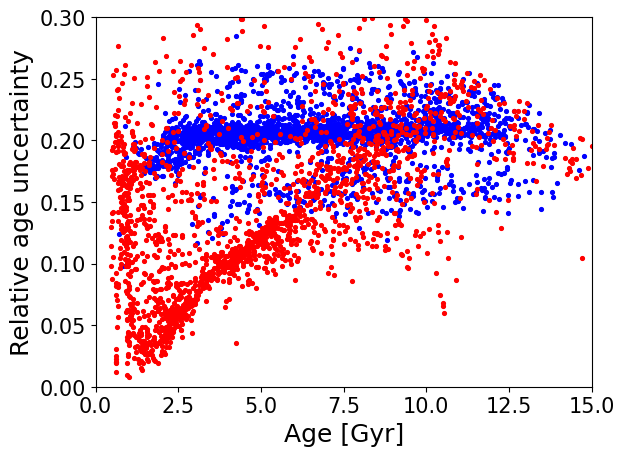

In [15]:
x = mig['age']
y = 0.5 * (mig['age_68U'] - mig['age_68L']) / mig["age"]

plt.scatter(x[rgb],y[rgb], c="b", s=7.5)
plt.scatter(x[rc], y[rc],  c="r", s=7.5)

plt.xlabel(r"Age [Gyr]", fontsize=18)
plt.ylabel(r"Relative age uncertainty", fontsize=18)
plt.savefig("../im/age_uncerts_training.png", dpi=300)

print("Median rel. age uncertainty for RGB:", np.nanmedian(y[rgb]))
print("Median rel. age uncertainty for RC:", np.nanmedian(y[rc]))
plt.axis([0,15,0,.3])

## Galactic distribution

In [ ]:
dr17_master = Table.read("/home/friedel/Astro/Spectro/APOGEE/data/DR17/APOGEE_DR17_MASTER_Feb2023.fits")
chem_age = np.isfinite(dr17_master['spec_age_feb2023'])

In [ ]:
plt.scatter(dr17_master['Rg'][chem_age], dr17_master['Zg'][chem_age], c="k", s=1, alpha=1, label="APOGEE DR17")
Ht,X1,X2 = np.histogram2d(dr17_master['Rg'][chem_age], dr17_master['Zg'][chem_age], 
                          bins=[320,120], range=[[0, 16], [-3, 3]])
Ht[Ht<2] = np.nan
image = plt.pcolor(0.5*(X1[:-1]+X1[1:]), 0.5*(X2[:-1]+X2[1:]), Ht.T, cmap="Greys_r", 
                   label=r"APOGEE DR17 giants", norm=colors.LogNorm())
plt.scatter(mig['GalR'][rgb], mig['GalZ'][rgb], s=5, c="b", label="Miglio+2021 RGB stars")
plt.scatter(mig['GalR'][rc],  mig['GalZ'][rc],  s=5, c="red", label="Miglio+2021 RC stars")
plt.axis([0, 16, -3, 3])
plt.xlabel(r"$R_{\rm Gal}$ [kpc]", fontsize=18)
plt.ylabel(r"$Z_{\rm Gal}$ [kpc]", fontsize=18)
plt.tight_layout()
plt.savefig("../im/RZ_training_vs_all.png", dpi=300)

# Create the actual training set

Now we create a pandas dataframe containing only the columns we think could be interesting to use in the training:

In [16]:
filtered_df = mig[['age',   'TEFF',  'LOGG', 
                   'C_FE',  'CI_FE', 'N_FE',  'O_FE', 
                   'NA_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'K_FE', 
                   'CA_FE', 'TI_FE', 'V_FE',  'MN_FE', 
                   'CO_FE', 'NI_FE' ]].copy() # excluding: ['FE_H', 'CE_FE']
filtered_df = filtered_df.dropna()
filtered_df = filtered_df.apply(pd.to_numeric, errors='coerce')

In [17]:
filtered_df.head()

,age,TEFF,LOGG,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,K_FE,CA_FE,TI_FE,V_FE,MN_FE,CO_FE,NI_FE
0,9.200530,4935.7446,3.005269,0.023162,-0.007958,0.057162,0.327843,0.009522,0.221213,0.165191,0.125141,-0.571301,0.125145,0.025540,0.318372,-0.079458,0.042810,0.047852
1,9.765974,4868.4120,2.896524,0.072861,0.166100,0.060547,0.351923,0.132742,0.334793,0.275611,0.217051,0.303809,0.215335,0.120983,0.135682,-0.133928,0.110210,0.084452
2,9.970859,4626.4370,2.377227,-0.019302,-0.080994,0.142940,0.058837,-0.106743,0.037074,0.008654,0.031735,0.095419,-0.032887,0.008246,-0.231145,0.030379,0.059327,0.000376
3,5.415645,4849.9243,2.507437,-0.103100,-0.102150,0.176710,0.057365,-0.037458,0.058243,0.144621,0.043489,0.086859,0.029885,0.003429,-0.034478,-0.006948,0.086580,0.018803
4,0.974770,4949.2600,2.796644,-0.151760,-0.247790,0.478130,0.027632,0.152182,-0.029237,0.008141,-0.004525,0.023149,-0.042264,-0.016344,-0.026019,0.077632,0.050500,0.039083


# Train XGBoost

In [18]:
# Define some functions that do the magic:

def split_train_test(filtered_df):
    # Split dataframe into input and output columns
    y = filtered_df['age']
    X = filtered_df.drop(columns = 'age')

    # Splitting into train and test (80% vs 20%)
    train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                        test_size = 0.2, 
                                                        random_state = 42)
    return train_X, test_X, train_y, test_y

def xgboost(filtered_df, params):
    # Create training and test parts
    train_X, test_X, train_y, test_y = split_train_test(filtered_df)
      
    # Instantiation
    model = xgb.XGBRegressor(**params, seed = 123)    
    model.fit(train_X, train_y)
    pred = model.predict(test_X)
    return model, test_y, pred

def gridsearch_xgboost(filtered_df):
    train_X, test_X, train_y, test_y = split_train_test(filtered_df)
    xgb1 = xgb.XGBRegressor()
    parameters = {
        'nthread':[4],
        'objective':['reg:squarederror', 'reg:pseudohubererror'],
        'learning_rate':[0.005, 0.01, 0.02, 0.04],
        'max_depth':[5, 6, 7],
        'min_child_weight': [4, 5, 6],
        'subsample':[0.6, 0.7, 0.8],
        'n_estimators':[500, 700, 1000, 1200, 1500]
    }
    xgb_grid = GridSearchCV(xgb1,
                            parameters,
                            cv=2,
                            n_jobs=2,
                            verbose=True)
    xgb_grid.fit(train_X,
                 train_y)
    return xgb_grid.best_params_

### Run gridsearch to optimise the hyperparameters:
Running the following cell takes a while (~30 min on an 8-core computer with 16GB RAM)... so it's not recommended to run it unless you really need it.

In [ ]:
# Full dataset:
best_params_all = gridsearch_xgboost(filtered_df)

# Consider fitting RGBs and RCs separately:
rgbs = filtered_df[mig["evstate"]==1]
best_params_rgb = gridsearch_xgboost(rgbs)

rcs  = filtered_df[mig["evstate"]==2]
best_params_rc  = gridsearch_xgboost(rcs)

Fitting 2 folds for each of 1080 candidates, totalling 2160 fits


In [ ]:
print("Best overall model:", best_params_all)
print("Best RGB model:", best_params_rgb)
print("Best RC model:", best_params_rc)

In case you didn't run the above cells - the results are:

In [19]:
best_params_all = {'learning_rate': 0.005, 'max_depth': 7, 'min_child_weight': 6, 
                   'n_estimators': 1500, 'nthread': 4, 'objective': 'reg:pseudohubererror', 'subsample': 0.7}
best_params_rgb = {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 
                   'n_estimators': 1200, 'nthread': 4, 'objective': 'reg:pseudohubererror', 'subsample': 0.7}
best_params_rc  = {'learning_rate': 0.005, 'max_depth': 6, 'min_child_weight': 4, 
                   'n_estimators': 700, 'nthread': 4, 'objective': 'reg:pseudohubererror', 'subsample': 0.6}

### Run the algorithm with optised hyperparameters:

In [20]:
filename = './models/default_model_m23p.pkl'
train_X, test_X, train_y, test_y = split_train_test(filtered_df)

if os.path.exists(filename):
    # Read the trained model from disk:
    model = pickle.load(open(filename, 'rb'))
else:
    # Instantiation
    model = xgb.XGBRegressor(**best_params_all, seed = 123)
    # Fit the model
    model.fit(train_X, train_y)
    # Save the model
    pickle.dump(model, open(filename, 'wb'))

# Predict the model
pred = model.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

#Score
result = model.score(test_X, test_y)
print("Score: "+str(result))

RMSE :  1.275273
Score: 0.8537705361330821


### Separate models for RGB and RC?

In [21]:
# Consider fitting RGBs and RCs separately:
rgbs = filtered_df[mig["evstate"]==1]
rcs  = filtered_df[mig["evstate"]==2]
model_rgb, test_rgb, pred_rgb = xgboost(rgbs, best_params_rgb)
model_rc,  test_rc,  pred_rc  = xgboost(rcs,  best_params_rc)
# Save these models:
pickle.dump(model_rgb, open('./models/rgb_model_m23p.pkl', 'wb'))
pickle.dump(model_rc,  open('./models/rc_model_m23p.pkl',  'wb'))

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


# Plots

In [22]:
def running_median(X, Y, nbins=10):
    bins = np.linspace(X.min(),X.max(), nbins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(X, bins, right=False)
    med = [np.quantile(Y[idx==k], 0.5) for k in range(1, nbins)]
    q16 = [np.quantile(Y[idx==k], 0.16) for k in range(1, nbins)]
    q84 = [np.quantile(Y[idx==k], 0.84) for k in range(1, nbins)]
    return bins[1:] - delta/2, med, q16, q84

# Overplot running median
def overplot_trend(X, Y, alpha=0.2, color="k", bins=10):
    #lines = mdline(X, Y, bins=bins)
    lines = running_median(X, Y, nbins=bins)
    xnew  = np.linspace(lines[0].min(), lines[0].max(), bins)
    spl   = make_interp_spline(lines[0], lines[1], k=2)
    power_smooth = spl(xnew)
    plt.plot(lines[0], lines[1], ms=50, color=color, lw=3)
    plt.fill_between(lines[0], lines[2], lines[3], alpha=alpha, color=color)

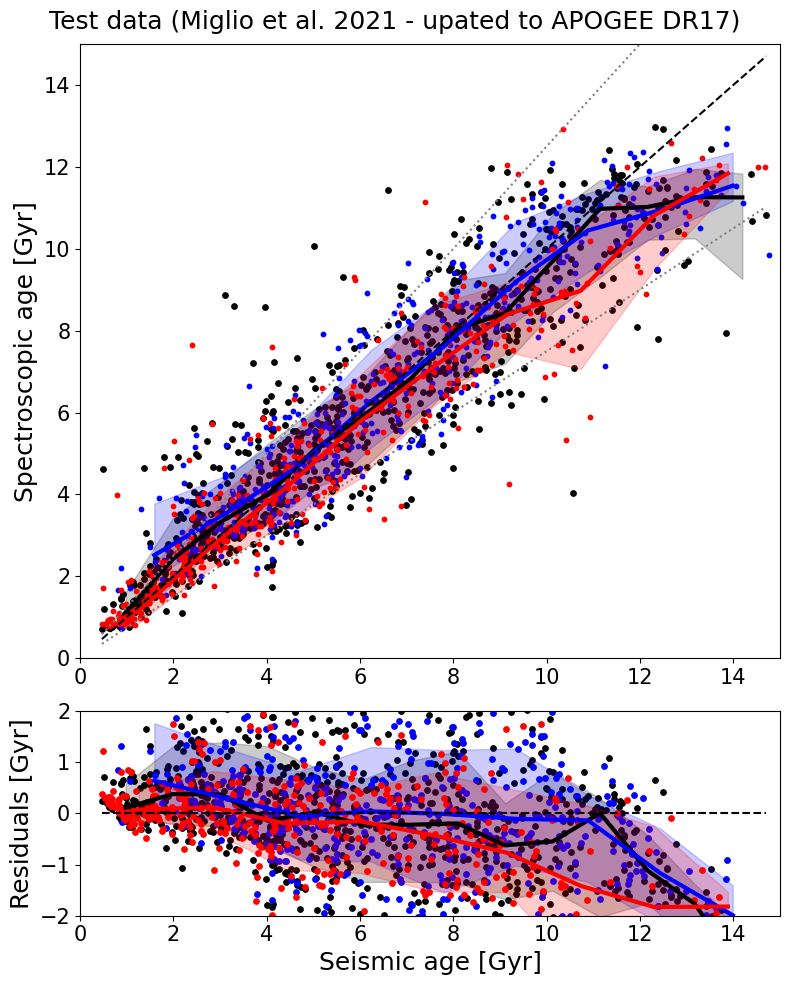

In [23]:
f, (a0, a1) = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(8,10))

plot_rgb_rc = True

# Top panel: predicted age vs. seismic age
plt.axes(a0)
a0.scatter(test_y, pred, c="k", s=15, label="Default model")
overplot_trend(test_y, pred, alpha=0.2, color="k", bins=15)
if plot_rgb_rc:
    a0.scatter(test_rgb, pred_rgb, c="b", s=10, label="RGB model")
    overplot_trend(test_rgb, pred_rgb, alpha=0.2, color="b", bins=10)
    a0.scatter(test_rc,  pred_rc, c="r", s=10, label="RC model")
    overplot_trend(test_rc,  pred_rc, alpha=0.2, color="r", bins=10)
xx = np.linspace(np.min(test_y), np.max(test_y), 20)
a0.plot(xx, xx, color = 'k', ls="dashed")
a0.plot(xx, 1.25*xx, color = 'grey', ls="dotted")
a0.plot(xx, 0.75*xx, color = 'grey', ls="dotted")
a0.set_ylabel(r"Spectroscopic age [Gyr]", fontsize=18)
#a0.legend(loc="upper left", fontsize=18)
a0.axis([0,15,0,15])

# Bottom panel: residuals
plt.axes(a1)
a1.scatter(test_y, pred-test_y, c="k", s=15)
overplot_trend(test_y, pred-test_y, alpha=0.2, color="k", bins=15)
if plot_rgb_rc:
    a1.scatter(test_rgb, pred_rgb-test_rgb, c="b", s=15)
    overplot_trend(test_rgb, pred_rgb-test_rgb, alpha=0.2, color="b", bins=10)
    a1.scatter(test_rc,  pred_rc-test_rc, c="r", s=15)
    overplot_trend(test_rc,  pred_rc-test_rc, alpha=0.2, color="r", bins=10)
a1.plot(xx, np.zeros(len(xx)), color = 'k', ls="dashed")
a1.set_xlabel(r"Seismic age [Gyr]", fontsize=18)
a1.set_ylabel(r"Residuals [Gyr]", fontsize=18)

a1.axis([0,15,-2, 2])
plt.suptitle("Test data (Miglio et al. 2021 - upated to APOGEE DR17)", fontsize=18)
plt.tight_layout()
plt.savefig("../im/predicted_vs_true_testdata.png")

# SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


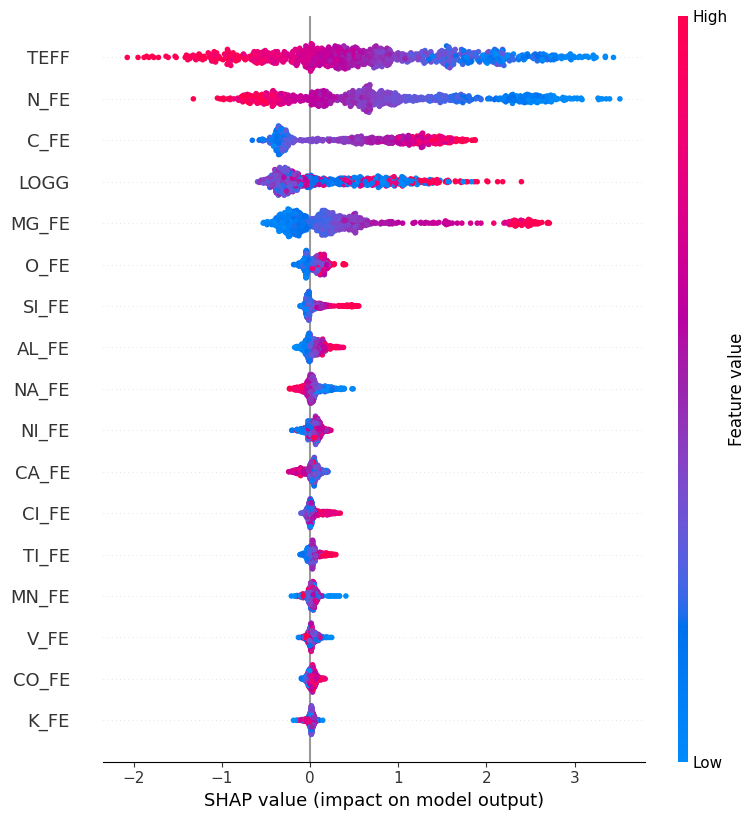

In [24]:
# Fits the explainer
explainer = shap.Explainer(model)
# Calculates the SHAP values - It might take some time
shap_values = explainer(test_X)
shap.summary_plot(shap_values, test_X, show=False)
# Same as
#shap.plots.beeswarm(shap_values)
plt.savefig("../im/shap_beeswarm.png", dpi=300)

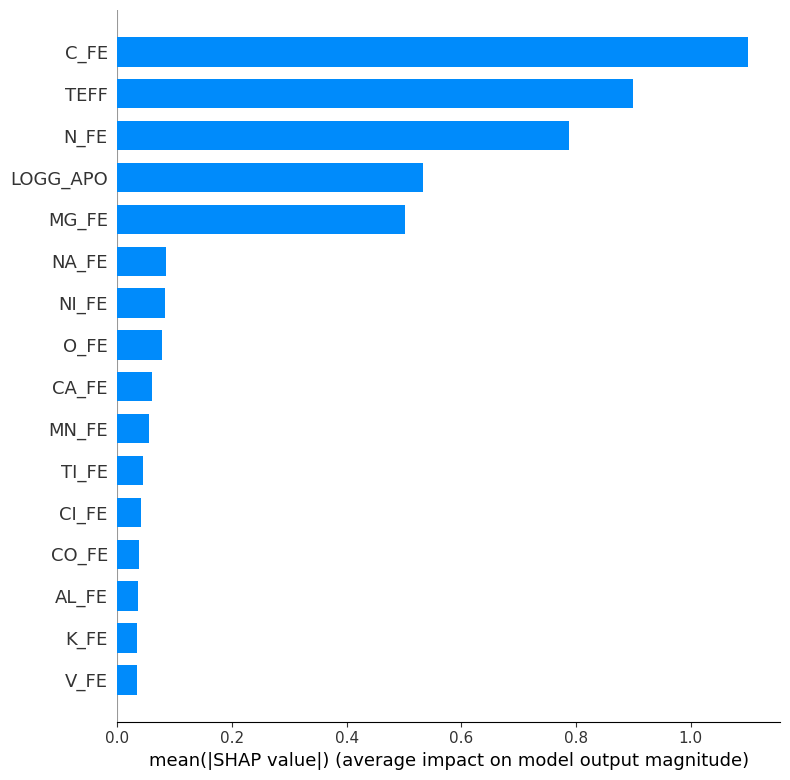

In [34]:
shap.summary_plot(shap_values, test_X, plot_type="bar")

# XGBOOST WITH PERTURBED DATA

# Estimate ages for the APOGEE DR17 data:

We already read the big file above:

In [41]:
big.head()

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,b'VESTA',b'apo1m',b'calibration',b' ',NaN,NaN,292.219131,-30.602919,99.999001,0.000,...,0.010266,0,NaN,NaN,0.059403,2,NaN,NaN,NaN,64
1,b'2M00000002+7417074',b'apo25m',b'120+12',b'none',0.000103,74.285408,119.401807,11.767414,8.597000,0.039,...,0.010609,0,NaN,NaN,0.001221,2,NaN,NaN,NaN,64
2,b'2M00000019-1924498',b'apo25m',b'060-75',b'none',0.000832,-19.413851,63.394122,-75.906397,11.074000,0.022,...,0.013835,0,NaN,NaN,0.102594,2,NaN,NaN,NaN,64
3,b'2M00000032+5737103',b'apo25m',b'116-04',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.016555,0,NaN,NaN,0.123839,2,NaN,NaN,NaN,64
4,b'2M00000032+5737103',b'apo25m',b'N7789',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.012638,0,NaN,NaN,0.107103,2,NaN,NaN,NaN,64


In [44]:
list(big.columns)

['APOGEE_ID',
 'TELESCOPE',
 'FIELD',
 'ALT_ID',
 'RA',
 'DEC',
 'GLON',
 'GLAT',
 'J',
 'J_ERR',
 'H',
 'H_ERR',
 'K',
 'K_ERR',
 'AK_TARG',
 'AK_TARG_METHOD',
 'AK_WISE',
 'SFD_EBV',
 'APOGEE_TARGET1',
 'APOGEE_TARGET2',
 'APOGEE2_TARGET1',
 'APOGEE2_TARGET2',
 'APOGEE2_TARGET3',
 'APOGEE2_TARGET4',
 'TARGFLAGS',
 'SURVEY',
 'PROGRAMNAME',
 'NVISITS',
 'SNR',
 'SNREV',
 'STARFLAG',
 'STARFLAGS',
 'ANDFLAG',
 'ANDFLAGS',
 'VHELIO_AVG',
 'VSCATTER',
 'VERR',
 'RV_TEFF',
 'RV_LOGG',
 'RV_FEH',
 'RV_ALPHA',
 'RV_CARB',
 'RV_CHI2',
 'RV_CCFWHM',
 'RV_AUTOFWHM',
 'RV_FLAG',
 'N_COMPONENTS',
 'MEANFIB',
 'SIGFIB',
 'MIN_H',
 'MAX_H',
 'MIN_JK',
 'MAX_JK',
 'GAIAEDR3_SOURCE_ID',
 'GAIAEDR3_PARALLAX',
 'GAIAEDR3_PARALLAX_ERROR',
 'GAIAEDR3_PMRA',
 'GAIAEDR3_PMRA_ERROR',
 'GAIAEDR3_PMDEC',
 'GAIAEDR3_PMDEC_ERROR',
 'GAIAEDR3_PHOT_G_MEAN_MAG',
 'GAIAEDR3_PHOT_BP_MEAN_MAG',
 'GAIAEDR3_PHOT_RP_MEAN_MAG',
 'GAIAEDR3_DR2_RADIAL_VELOCITY',
 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR',
 'GAIAEDR3_R_MED_GEO'

Now let's cut out the sample we wish to calculate ages for - and apply the XGBoost model:

In [76]:
features = ['TEFF', 'LOGG', 
            'C_FE',  'CI_FE', 'N_FE', 'O_FE', 
            'NA_FE', 'MG_FE', 'AL_FE', 'K_FE', 
            'CA_FE', 'TI_FE', 'V_FE', 'MN_FE', 
            'CO_FE', 'NI_FE']
# For the method to work, we require good measurements for the main features 
#  {[C/Fe], Teff, [N/Fe], [Mg/Fe], log g} etc... (see above for all the criteria)
sel_big = big[selection].dropna(subset=features)
sel_big = sel_big.set_index('APOGEE_ID')

Now filter the necessary columns:

In [60]:
filtered_big = sel_big[features].copy()
filtered_big = filtered_big.dropna()
filtered_big = filtered_big.apply(pd.to_numeric, errors='coerce')

print(len(filtered_big), "stars will be used")

193933 stars will be used


Use the model to infer the age:

In [61]:
pred_big = model.predict(filtered_big)

### Save the results as a table

In [62]:
save_big = filtered_big.copy()
save_big["spec_age_feb2023"] = np.round(pred_big, 2)
save_big = save_big.drop(columns=features)

### Add columns describing the bias and statistical uncertainties 

To do this, we use the comparison with the test sample from above (but now showing the residuals as a function of estimated age):

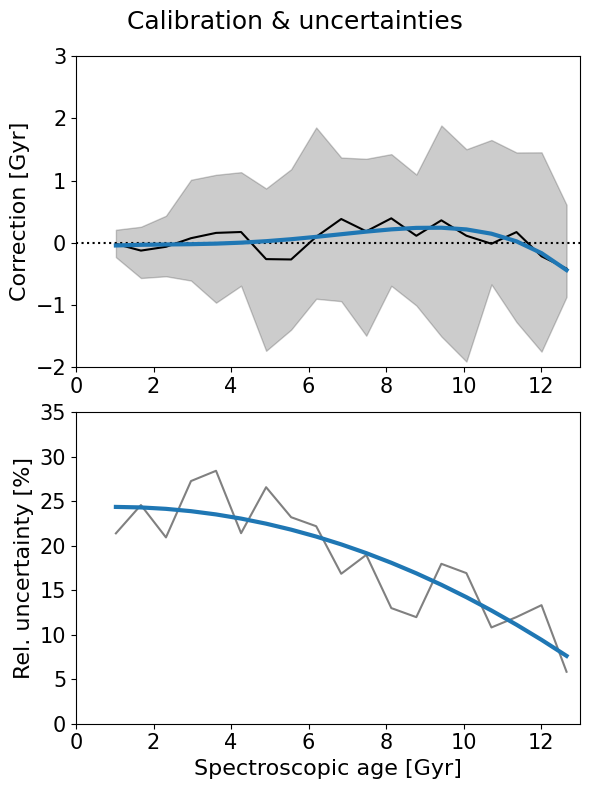

In [25]:
agebins, med, q16, q84 = running_median(pred, test_y-pred, nbins=20)

f, (a0, a1) = plt.subplots(2, 1, height_ratios=[1, 1], figsize=(6,8))

plt.axes(a0)
plt.hlines(0,0,13, color="k", ls="dotted")
plt.axis([0,13,-2,3])
plt.plot(agebins, med, color="k")
plt.fill_between(agebins, q84, q16, alpha=.2, color="k")
med_fit = np.polyfit(agebins, med, 4)
p1 = np.poly1d(med_fit)
plt.plot(agebins, p1(agebins), lw=3)
plt.ylabel(r"Correction [Gyr]", fontsize=16)

plt.axes(a1)
uncert = 50.*(np.array(q84)-np.array(q16)) / np.array(agebins)
plt.plot(agebins, uncert, color="grey")
unc_fit = np.polyfit(agebins, uncert, 2)
p2 = np.poly1d(unc_fit)
plt.plot(agebins, p2(agebins), lw=3)
plt.axis([0,13,0,35])
plt.xlabel(r"Spectroscopic age [Gyr]", fontsize=16)
plt.ylabel(r"Rel. uncertainty [%]", fontsize=16)
plt.suptitle(r"Calibration & uncertainties", fontsize=18)
plt.tight_layout()
plt.savefig("../im/estimating_uncertainties.png")

### Define columns containing the calibrated ages and uncertainties - then save this

In [69]:
save_big["spec_age_feb2023_calib"]  = np.round(pred_big + p1(pred_big), 2)
save_big["spec_age_feb2023_uncert"] = np.round(0.01 * p2(pred_big) * pred_big, 2)
save_big.to_csv("../data/spec_ages_feb2023.csv")

### Have a look at the big table

In [78]:
sel_big["spec_age_feb2023"]        = np.array(save_big["spec_age_feb2023"])
sel_big["spec_age_feb2023_calib"]  = np.array(save_big["spec_age_feb2023_calib"])
sel_big["spec_age_feb2023_uncert"] = np.array(save_big["spec_age_feb2023_uncert"])

In [79]:
sel_big

,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,...,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,spec_age_feb2023,spec_age_feb2023_calib,spec_age_feb2023_uncert
APOGEE_ID,,,,,,,,,,,,,,,,,,,,,
b'2M00000133+5721163',b'apo25m',b'NGC7789_btx',b'none',0.005558,57.354549,116.014776,-4.824917,13.261,0.029,12.605,...,NaN,0.025131,2,-0.256490,-0.200830,0.132389,0,4.19,4.21,0.87
b'2M00000211+6327470',b'apo25m',b'117+01',b'none',0.008802,63.463078,117.227985,1.162167,11.880,0.024,11.107,...,NaN,NaN,259,0.194041,0.249701,0.070006,0,3.98,3.97,0.83
b'2M00000222+5625359',b'apo25m',b'N7789',b'none',0.009287,56.426662,115.831519,-5.734687,11.982,0.023,11.433,...,NaN,0.007840,2,-0.356350,-0.300690,0.131302,0,4.16,4.19,0.86
b'2M00000446+5854329',b'apo25m',b'116-04',b'none',0.018603,58.909149,116.330761,-3.302585,12.255,0.023,11.489,...,NaN,NaN,259,0.208779,0.264439,0.087975,0,4.08,4.09,0.85
b'2M00000506+5656353',b'apo25m',b'NGC7789_MGA',b'none',0.021113,56.943142,115.941040,-5.229802,9.317,0.026,8.717,...,NaN,0.009407,2,0.030740,0.086400,0.083735,0,4.02,4.02,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'2M23595553+6339020',b'apo25m',b'117+01',b'none',359.981416,63.650566,117.253198,1.348353,12.551,0.027,11.857,...,NaN,NaN,259,0.247312,0.302972,0.139169,0,1.06,1.06,0.23
b'2M23595669+6131251',b'apo25m',b'116+00',b'none',359.986225,61.523659,116.833497,-0.736743,11.698,0.026,11.048,...,NaN,0.014083,2,-0.017480,0.038180,0.112270,0,2.83,2.65,0.60
b'2M23595837+5700444',b'apo25m',b'N7789',b'none',359.993224,57.012356,115.939899,-5.158948,12.657,0.026,11.992,...,NaN,0.016774,2,-0.035640,0.020020,0.141408,0,4.07,4.08,0.84


In [95]:
print("Median age uncertainty:", np.median(sel_big["spec_age_feb2023_uncert"]), "Gyr")
print("Median relative age uncertainty:", np.round(100.*np.median(sel_big["spec_age_feb2023_uncert"] / sel_big["spec_age_feb2023_calib"]),1), "%")


Median age uncertainty: 1.17 Gyr
Median relative age uncertainty: 18.3 %


## Use internal cross-match to get rid of duplicates and estimate internal uncertainties